<span style="color:red">**_This notebook is for execution on GPU notes only!_**</span>

# Introduction to Dask cuDF

[Dask](https://dask.org/) cuDF can be used to distribute dataframe operations to multiple GPUs. In this notebook we will introduce some key Dask concepts, learn how to setup a Dask cluster for utilizing multiple GPUs, and see how to perform simple dataframe operations on distributed Dask dataframes.

In particular, we will use a Dask-cuDF dataframe, which combines the interface of Dask with the GPU power of cuDF for distributed dataframe operations on multiple GPUs. We will now turn our attention to utilizing 2 NVIDIA A40 GPUs in this environment for operations on the previously used airport data set.

## Objectives

By the time you complete this notebook you will be able to:

- Create a Dask GPU Cluster
- Create and execute Dask cuDF dataframe computational graphs on multiple GPUs

## Setting up a Dask Scheduler

### Starting a `LocalCUDACluster`

We begin by starting a Dask scheduler which will take care to distribute our work across the 2 available GPUs. In order to do this we need to start a `LocalCUDACluster` instance. You need to go to the Dask symbol on the left sidebar and click on `+NEW` at the bottom. Then, click on the `<>` symbol bottom left. All you need to do now is run the cell.

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36189")
client

<Client: 'tcp://127.0.0.1:36189' processes=1 threads=1, memory=123.05 GiB>

`dask_cuda` provides utilities for Dask and CUDA (the "cu" in cuDF) interactions.

## Reading Data with Dask cuDF

With `dask_cudf` we can create a dataframe from several file formats (including from multiple files and directly from cloud storage like S3), from cuDF dataframes, from Pandas dataframes, and even from vanilla CPU Dask dataframes. Here we will create a Dask cuDF dataframe from the previously used Airport data set.

We import dask_cudf (and other RAPIDS components when necessary) after setting up the cluster to ensure that they establish correctly inside the CUDA context it creates.

In [2]:
import dask_cudf
import os
from glob import glob

In [3]:
filenames = sorted(glob(os.path.join("data", "nycflights", "*.csv")))

In [4]:
filenames

['data/nycflights/1990.csv',
 'data/nycflights/1991.csv',
 'data/nycflights/1992.csv',
 'data/nycflights/1993.csv',
 'data/nycflights/1994.csv',
 'data/nycflights/1995.csv',
 'data/nycflights/1996.csv',
 'data/nycflights/1997.csv',
 'data/nycflights/1998.csv',
 'data/nycflights/1999.csv']

In [5]:
filepath = glob("./data/nycflights/*.csv")

Just like in pandas, we need to use concat when reading multiple files into one Dataframe:

In [6]:
gdf = dask_cudf.DataFrame
df_list = []
datatypes = {"Year":int,"Month":int,"DayofMonth":int,
                                                "DayOfWeek":int, "DepTime":float, "CRSDepTime":int,
                                                "ArrTime":float, "CRSArrTime":int, "UniqueCarrier":str,
                                                "FlightNum":int, "TailNum":str, "ActualElapsedTime":float,
                                                "CRSElapsedTime":int, "AirTime":float, "ArrDelay":float,
                                                "DepDelay":float, "Origin":str, "Dest":str, "Distance":float,
                                                "TaxiIn":float, "TaxiOut":float, "Cancelled":bool, "Diverted":bool}

In [7]:
for f in filenames:
    df = dask_cudf.read_csv(f, dtype=datatypes)
    df_list.append(df)
gdf = dask_cudf.concat(df_list,  ignore_index=True)

In [8]:
gdf.tail()

FileNotFoundError: [Errno 2] No such file or directory: 'data/nycflights/1999.csv'

In [9]:
gdf.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum               object
ActualElapsedTime    float64
CRSElapsedTime         int64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance             float64
TaxiIn               float64
TaxiOut              float64
Cancelled               bool
Diverted                bool
dtype: object

In [10]:
!nvidia-smi

Mon Jul 25 23:25:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          Off  | 00000000:41:00.0 Off |                    0 |
|  0%   37C    P0    77W / 300W |   1121MiB / 46068MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A40          Off  | 00000000:A1:00.0 Off |                    0 |
|  0%   

## Visualizing the Computational Graph

As we have seen before, computational graphs that have not yet been executed provide the `.visualize` method that, when used in a Jupyter environment such as this one, will display the computational graph, including how Dask intends to go about distributing the work. Thus, we can visualize how the `read_csv` operation will be distributed by Dask by executing the following cell:

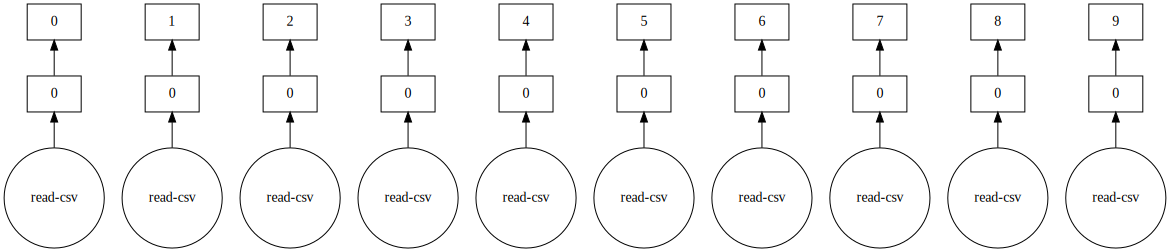

In [11]:
gdf.visualize(format='svg') # This visualization is very large, and using `format='svg'` will make it easier to view.

As you can see, when we indicate for Dask to actually execute this operation, it will parallelize the work across the 2 GPUs in something like 10 parallel partitions. We can see the exact number of partitions with the `npartitions` property:

In [12]:
gdf.npartitions

10

## Extending the Computational Graph

The concept of constructing computational graphs with arbitrary operations before executing them is a core part of Dask. Let's add some operations to the existing computational graph and visualize it again.

After running the next cell, although it will take some scrolling to get a clear sense of it (the challenges of distributed data analytics!), you can see that the graph already constructed for `read_csv` now continues upward. It selects the `DepDelay` column across all partitions (visualized as `getitem`) and eventually performs the `.mean()` reduction (visualized as `series-sum-chunk`, `series-sum-agg`, `count-chunk`, `sum-agg` and `true-div`).

In [13]:
mean_DepDelay = gdf["DepDelay"].mean()

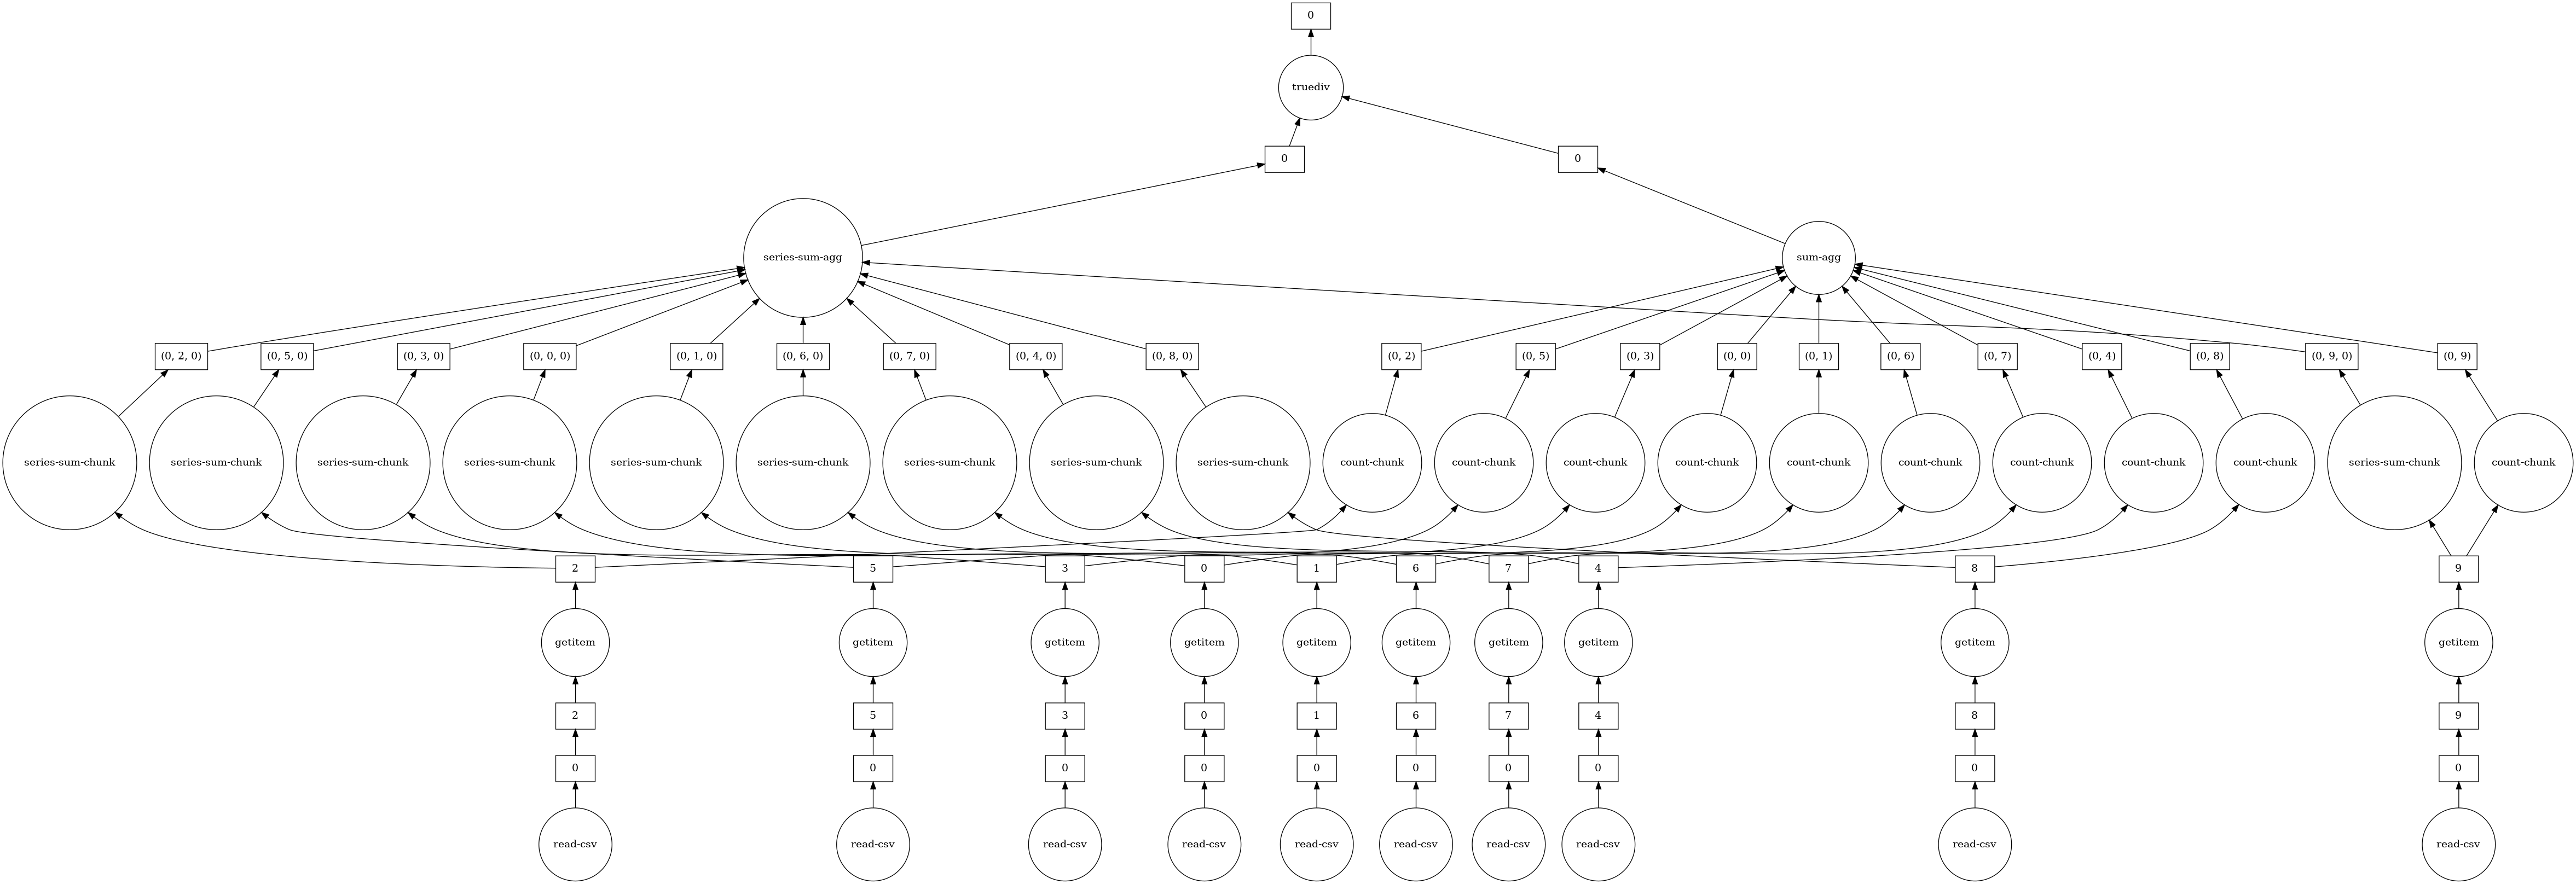

In [14]:
mean_DepDelay.visualize() # mean_DepDelay.visualize(format = "svg") provides a close-up

## Computing with the Computational Graph

There are several ways to indicate to Dask that we would like to perform the computations described in the computational graphs we have constructed. The first we will show is the `.compute` method, which will return the output of the computation as an object in one GPU's memory - no longer distributed across GPUs.

(**NOTE**: This value is actually a [*future*](https://docs.python.org/3/library/concurrent.futures.html) that it can be immediately used in code, even before it completes evaluating. While this can be tremendously useful in many scenarios, we will not do anything fancy with the futures we generate here except to wait for them to evaluate so we can visualize their values).

Execute the following cell to send the computational graph we have created to the Dask scheduler to be executed in parallel on our 2 GPUs. If you have the Dask Dashboard open on another tab from before, you can watch it while the operation completes. If you closely watch the dashboard, you will see that Dask begins follow-on calculations for `mean` even while data is still being read into memory.

In [15]:
%time mean_DepDelay.compute()

FileNotFoundError: [Errno 2] No such file or directory: 'data/nycflights/1997.csv'

### Persisting Data in the Cluster

As you can see, the previous operation, which read the entire csv into the GPUs' memory, did not retain the data in memory after completing the computational graph:

In [16]:
!nvidia-smi

Mon Jul 25 23:25:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          Off  | 00000000:41:00.0 Off |                    0 |
|  0%   37C    P0    77W / 300W |   1121MiB / 46068MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A40          Off  | 00000000:A1:00.0 Off |                    0 |
|  0%   

A typical Dask workflow, which we will utilize, is to persist data we would like to work with to the cluster and then perform fast operations on that persisted data. We do this with the `.persist` method. From the [Dask documentation](https://distributed.dask.org/en/latest/manage-computation.html#client-persist):

>The `.persist` method submits the task graph behind the Dask collection to the scheduler, obtaining Futures for all of the top-most tasks (for example one Future for each Pandas [*or cuDF*] DataFrame in a Dask[*-cudf*] DataFrame). It then returns a copy of the collection pointing to these futures instead of the previous graph. This new collection is semantically equivalent but now points to actively running data rather than a lazy graph.

Here we persist `ddf` to the cluster so that it will reside in GPU memory for us to perform fast operations on:

In [18]:
gdf = gdf.persist()

As you can see by executing `nvidia-smi` (after letting the `persist` finish), each GPU now has parts of the distributed dataframe in its memory:

In [19]:
!nvidia-smi

Mon Jul 25 23:26:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          Off  | 00000000:41:00.0 Off |                    0 |
|  0%   38C    P0    77W / 300W |   1121MiB / 46068MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A40          Off  | 00000000:A1:00.0 Off |                    0 |
|  0%   

Running `ddf.visualize` now shows that we no longer have operations in our task graph, only partitions of data, ready for us to perform operations:

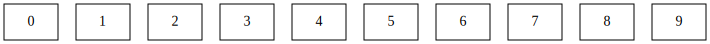

In [20]:
gdf.visualize(format='svg')

Computing operations on this data will now be much faster:

In [21]:
%time gdf["DepDelay"].mean().compute()

FileNotFoundError: [Errno 2] No such file or directory: 'data/nycflights/1999.csv'

In [22]:
!nvidia-smi

Mon Jul 25 23:26:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          Off  | 00000000:41:00.0 Off |                    0 |
|  0%   38C    P0    77W / 300W |   1121MiB / 46068MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A40          Off  | 00000000:A1:00.0 Off |                    0 |
|  0%   

## Initial Data Exploration with Dask cuDF

The beauty of Dask is that working with your data, even though it is distributed and massive, is a lot like working with smaller in-memory data sets.

In [23]:
gdf.head() # As a convenience, no need to `.compute` the `head()` method

FileNotFoundError: [Errno 2] No such file or directory: 'data/nycflights/1990.csv'

In [24]:
%time gdf.count().compute()

FileNotFoundError: [Errno 2] No such file or directory: 'data/nycflights/1999.csv'

## Exercise: Airports at a greater distance than 1000 miles from Newark (EWR)

Here, we are asking you to produce a dask_cudf series with airports (each mentioned once, using the unique() method) that are at a greater distance than 1000 miles from Newark (EWR). Also, you should calculate the average (mean) distance between these airports and Newark.

#### Solution

In [26]:
# %load solutions/counties_north_of_sunderland_ddf
newark = gdf.loc[ddf["Origin"] == "EWR"]
far_from_newark = newark.loc[newark["Distance"] > 1000]

NameError: name 'ddf' is not defined

In [27]:
far_from_newark["Distance"].mean().compute()

NameError: name 'far_from_newark' is not defined

In [28]:
far_from_newark["Dest"].unique().compute()

NameError: name 'far_from_newark' is not defined

<br>
<div align="center"><h2>Please Restart the Kernel</h2></div>

In [29]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## Next

With this introduction to Dask cuDF, you will now proceed in the next notebook to do more advanced data transformation with Dask, revisiting the grid coordinate converter function, but applying it to the 18GB 5x UK population data set.